In [1]:
import os
import time
import socket
import xarray as xr
import rioxarray
import numpy as np
import dask.array as da
from odc.stac import load as odc_load
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=8, threads_per_worker=1, memory_limit="30GB")
# client = Client(cluster)


In [2]:
def load_glance_local(stac_path: str, year: int, geobox, chunk_size=2048):
    """
    Load GLANCE items for a given year and align to the provided geobox.
    Returns a single xarray.DataArray (squeezed time dim).
    """
    import pystac
    cat = pystac.Catalog.from_file(stac_path)
    items = [it for it in cat.get_items(recursive=True)
             if getattr(it, "datetime", None) and it.datetime.year == year]
    if not items:
        raise RuntimeError(f"No GLANCE items found for year {year}")

    ds = odc_load(
        items,
        geobox=geobox,
        chunks={"x": chunk_size, "y": chunk_size},
        resampling="nearest",
        fail_on_error=False,
    )

    # choose first datavar unless you know exact name
    var = next(iter(ds.data_vars))
    gl = ds[var].squeeze(drop=True)

    # normalize dim names
    rename = {}
    if "latitude" in gl.dims:
        rename["latitude"] = "y"
    if "longitude" in gl.dims:
        rename["longitude"] = "x"
    if rename:
        gl = gl.rename(rename)

    return gl

# paths
year = 2016
chunk_size = 1024*4  # for both x and y
stac_path = "/projectnb/modislc/users/chishan/stac_glance_SA_fixed_m/catalog.json"
mb_path   = f"/projectnb/modislc/users/chishan/data/MapBiomas/COG/AMZ.{year}.M.cog.tif"

# load MapBiomas COG (chunks aligne)
mb = rioxarray.open_rasterio(mb_path, chunks={"y": chunk_size, "x": chunk_size}).squeeze(drop=True)
if "latitude" in mb.dims or "longitude" in mb.dims:
    mb = mb.rename({"latitude": "y", "longitude": "x"})
mb_nodata = mb.rio.nodata if mb.rio.nodata is not None else 0
print(f"✓ MapBiomas loaded: shape={mb.shape}, dims={mb.dims}, CRS={mb.rio.crs}, nodata={mb_nodata}")
print(f"  Geobox: width={mb.odc.geobox.width}, height={mb.odc.geobox.height}, res={mb.odc.geobox.resolution}")

# load GLANCE aligned to MapBiomas grid
gl = load_glance_local(stac_path, year, geobox=mb.odc.geobox, chunk_size=chunk_size)
gl_nodata = gl.rio.nodata if hasattr(gl, "rio") and (gl.rio.nodata is not None) else 255
print(f"✓ GLANCE loaded: shape={gl.shape}, dims={gl.dims}, nodata={gl_nodata}")


✓ MapBiomas loaded: shape=(243684, 339821), dims=('y', 'x'), CRS=EPSG:4674, nodata=0
  Geobox: width=339821, height=243684, res=Resolution(x=9e-05, y=-9e-05)
✓ GLANCE loaded: shape=(243684, 339821), dims=('y', 'x'), nodata=255


In [3]:
gl


<xarray.DataArray 'data' (y: 243684, x: 339821)> Size: 331GB
dask.array<getitem, shape=(243684, 339821), dtype=float32, chunksize=(4096, 4096), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2MB 5.27 5.269 5.269 5.269 ... -16.66 -16.66 -16.66
  * x            (x) float64 3MB -73.98 -73.98 -73.98 ... -43.4 -43.4 -43.4
    spatial_ref  int32 4B 4674

In [ ]:
gl_nodata


255

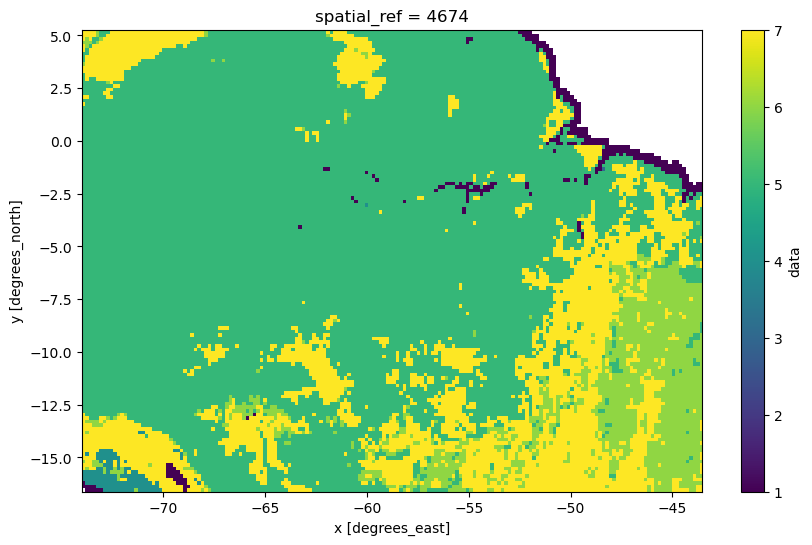

In [ ]:
gl_small = gl.coarsen(y=1900, x=1900, boundary="trim").median().compute()
gl_small_nodata = gl_small.where(gl_small != gl_nodata)
gl_small_nodata.plot.imshow(figsize=(10,6))


In [ ]:
from shapely.geometry import shape
import geopandas as gpd
import pystac

cat = pystac.Catalog.from_file(stac_path)
items = [it for it in cat.get_items(recursive=True)
         if getattr(it, "datetime", None) and it.datetime.year == year]

records = []
for it in items:
    geom = shape(it.geometry)                    # 当前 item 的 footprint
    records.append({"id": it.id,
                    "time": it.datetime,
                    "geometry": geom})

gdf = gpd.GeoDataFrame(records, geometry="geometry", crs="EPSG:4326")
gdf


,id,time,geometry
0,glance_2016_h14v46,2016-07-01 00:00:00+00:00,"POLYGON ((-108.92248 -28.31779, -108.92248 -26..."
1,glance_2016_h16v44,2016-07-01 00:00:00+00:00,"POLYGON ((-104.8223 -26.66138, -104.8223 -25.1..."
2,glance_2016_h14v45,2016-07-01 00:00:00+00:00,"POLYGON ((-108.39088 -27.1364, -108.39088 -25...."
3,glance_2016_h16v45,2016-07-01 00:00:00+00:00,"POLYGON ((-105.30317 -27.8698, -105.30317 -26...."
4,glance_2016_h17v44,2016-07-01 00:00:00+00:00,"POLYGON ((-103.28998 -27.00076, -103.28998 -25..."
...,...,...,...
1007,glance_2016_h64v29,2016-07-01 00:00:00+00:00,"POLYGON ((-33.94523 -10.13224, -33.94523 -8.67..."
1008,glance_2016_h65v25,2016-07-01 00:00:00+00:00,"POLYGON ((-32.97056 -4.70481, -32.97056 -3.247..."
1009,glance_2016_h67v38,2016-07-01 00:00:00+00:00,"POLYGON ((-27.9096 -21.38647, -27.9096 -19.882..."
1010,glance_2016_h66v25,2016-07-01 00:00:00+00:00,"POLYGON ((-31.58936 -4.56951, -31.58936 -3.109..."


Text(0.5, 1.0, 'GLANCE footprints vs MapBiomas geobox (2016)')

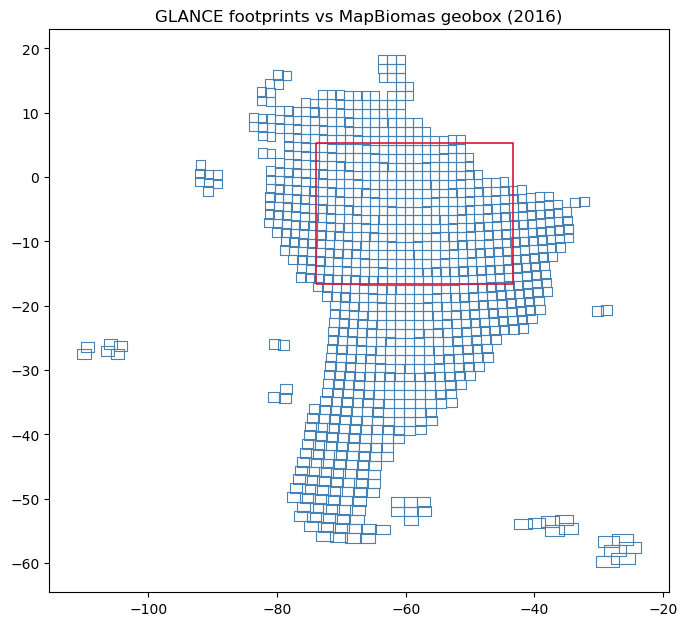

In [7]:
query_geom = mb.odc.geobox.extent.to_crs("EPSG:4326")
ax = gdf.boundary.plot(figsize=(8, 8), linewidth=0.8, color="steelblue")
gpd.GeoSeries([query_geom.geom]).boundary.plot(ax=ax, color="crimson", linewidth=1.2)
ax.set_title(f"GLANCE footprints vs MapBiomas geobox ({year})")


In [8]:
from shapely.geometry import shape
import geopandas as gpd
import pystac
year=2018

cat = pystac.Catalog.from_file(stac_path)
items = [it for it in cat.get_items(recursive=True)
         if getattr(it, "datetime", None) and it.datetime.year == year]

records = []
for it in items:
    geom = shape(it.geometry)                    # 当前 item 的 footprint
    records.append({"id": it.id,
                    "time": it.datetime,
                    "geometry": geom})

gdf = gpd.GeoDataFrame(records, geometry="geometry", crs="EPSG:4326")
gdf


,id,time,geometry
0,glance_2018_h14v45,2018-07-01 00:00:00+00:00,"POLYGON ((-108.39088 -27.1364, -108.39088 -25...."
1,glance_2018_h16v44,2018-07-01 00:00:00+00:00,"POLYGON ((-104.8223 -26.66138, -104.8223 -25.1..."
2,glance_2018_h16v45,2018-07-01 00:00:00+00:00,"POLYGON ((-105.30317 -27.8698, -105.30317 -26...."
3,glance_2018_h17v44,2018-07-01 00:00:00+00:00,"POLYGON ((-103.28998 -27.00076, -103.28998 -25..."
4,glance_2018_h14v46,2018-07-01 00:00:00+00:00,"POLYGON ((-108.92248 -28.31779, -108.92248 -26..."
...,...,...,...
1007,glance_2018_h64v29,2018-07-01 00:00:00+00:00,"POLYGON ((-33.94523 -10.13224, -33.94523 -8.67..."
1008,glance_2018_h65v25,2018-07-01 00:00:00+00:00,"POLYGON ((-32.97056 -4.70481, -32.97056 -3.247..."
1009,glance_2018_h66v25,2018-07-01 00:00:00+00:00,"POLYGON ((-31.58936 -4.56951, -31.58936 -3.109..."
1010,glance_2018_h66v38,2018-07-01 00:00:00+00:00,"POLYGON ((-29.3814 -21.59175, -29.3814 -20.091..."


Text(0.5, 1.0, 'GLANCE footprints vs MapBiomas geobox (2018)')

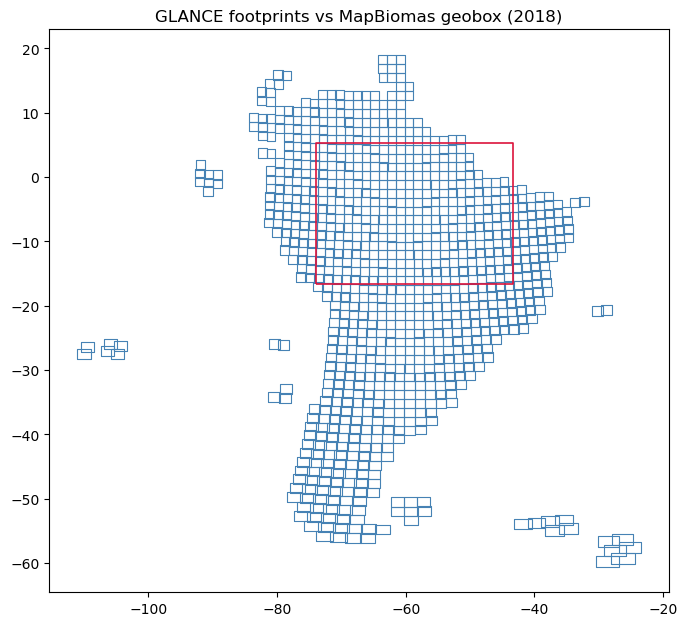

In [9]:
query_geom = mb.odc.geobox.extent.to_crs("EPSG:4326")
ax = gdf.boundary.plot(figsize=(8, 8), linewidth=0.8, color="steelblue")
gpd.GeoSeries([query_geom.geom]).boundary.plot(ax=ax, color="crimson", linewidth=1.2)
ax.set_title(f"GLANCE footprints vs MapBiomas geobox ({year})")


In [ ]:
from datacube import Datacube
from datacube.utils.geometry import CRS
import geopandas as gpd

dc = Datacube()
query = dict(product='glance',
             time=('2016-10-01', '2016-10-31'),
             geopolygon=your_query_geometry)  # 例如 polygon 或 bbox
datasets = dc.index.datasets.search(**query)

records = []
for ds in datasets:
    geom = ds.extent  # datacube.utils.geometry.Geometry
    records.append(dict(id=str(ds.id),
                        start=ds.center_time,
                        geometry=geom.to_crs(CRS("EPSG:4326")).geom))
    
gdf = gpd.GeoDataFrame(records, geometry='geometry', crs="EPSG:4326")


In [ ]:
mb


<xarray.DataArray (y: 243684, x: 339821)> Size: 83GB
dask.array<getitem, shape=(243684, 339821), dtype=uint8, chunksize=(4096, 4096), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 3MB -73.98 -73.98 -73.98 ... -43.4 -43.4 -43.4
  * y            (y) float64 2MB 5.27 5.269 5.269 5.269 ... -16.66 -16.66 -16.66
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

In [ ]:
gl_nodata


255

In [22]:
gl.rio.nodata


In [ ]:
gl_small = mb.coarsen(y=16, x=16, boundary="trim").mean().compute()
gl_small.plot.imshow(figsize=(10,6))


In [ ]:
win = {"y": slice(0,2000), "x": slice(0,2000)}
mb_preview = mb.isel(**win).compute()   # 只把这块拉下来
mb_preview.plot.imshow(figsize=(8,8))


In [ ]:
# 1. 建 cluster（会提交 jobs）
from dask_jobqueue import SGECluster
from dask.distributed import Client
import os
cluster = SGECluster(cores=8, processes=8, memory="100GB",
                     job_extra_directives=[f"-pe omp {8}", "-l mem_per_core=12G", "-V"],
                     local_directory=os.environ.get("TMPDIR","/projectnb/modislc/users/chishan/tmp"),
                     scheduler_options={"dashboard_address": ":8787"})
cluster.scale(jobs=4)
client = Client(cluster)
print("dashboard:", client.dashboard_link)

# 2. load your data (assume gl already loaded earlier)
# gl = load_glance_local(...)


dashboard: http://192.168.17.101:8787/status


In [3]:
# paths
year = 2016
chunk_size = int(1024*4)  # for both x and y
stac_path = "/projectnb/modislc/users/chishan/stac_glance_SA_fixed_m/catalog.json"
mb_path   = f"/projectnb/modislc/users/chishan/data/MapBiomas/COG/AMZ.{year}.M.cog.tif"

# load MapBiomas COG (chunks aligne)
mb = rioxarray.open_rasterio(mb_path, chunks={"y": chunk_size, "x": chunk_size}).squeeze(drop=True)
if "latitude" in mb.dims or "longitude" in mb.dims:
    mb = mb.rename({"latitude": "y", "longitude": "x"})
mb_nodata = mb.rio.nodata if mb.rio.nodata is not None else 0
print(f"✓ MapBiomas loaded: shape={mb.shape}, dims={mb.dims}, CRS={mb.rio.crs}, nodata={mb_nodata}")
print(f"  Geobox: width={mb.odc.geobox.width}, height={mb.odc.geobox.height}, res={mb.odc.geobox.resolution}")


✓ MapBiomas loaded: shape=(243684, 339821), dims=('y', 'x'), CRS=EPSG:4674, nodata=0
  Geobox: width=339821, height=243684, res=Resolution(x=9e-05, y=-9e-05)


In [ ]:
mb


<xarray.DataArray (y: 243684, x: 339821)> Size: 83GB
dask.array<getitem, shape=(243684, 339821), dtype=uint8, chunksize=(4096, 4096), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 3MB -73.98 -73.98 -73.98 ... -43.4 -43.4 -43.4
  * y            (y) float64 2MB 5.27 5.269 5.269 5.269 ... -16.66 -16.66 -16.66
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

In [ ]:
mb.rio.nodata


np.uint8(0)

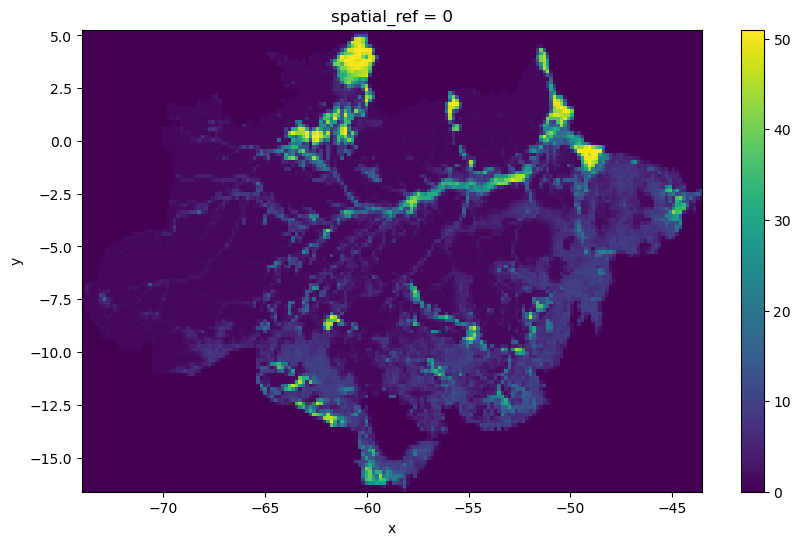

In [ ]:
# 按更大块做平均，例如 64×64 或 128×128
mb_small = mb.coarsen(y=1900, x=1900, boundary="trim").median().compute()
mb_small.plot.imshow(figsize=(10,6))


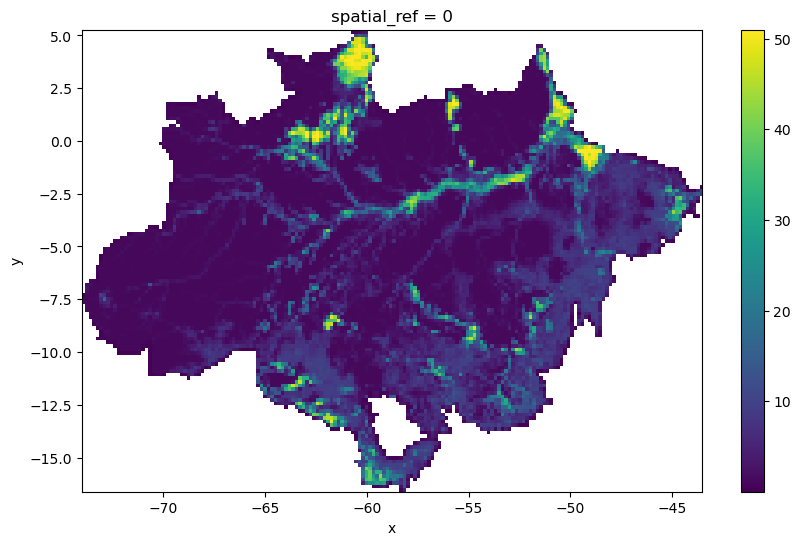

In [ ]:
gl_small_non = gl_small.where(gl_small != 0)
gl_small_non.plot.imshow(figsize=(10, 6))


In [ ]:
mb_nodata


np.uint8(0)

In [ ]:
mb_small = gl.coarsen(y=1900, x=1900, boundary="trim").median().compute()
mb_small.plot.imshow(figsize=(10,6))


In [ ]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

mb_nan = mb.where(mb != 0)

mb_small = mb_nan.coarsen(y=1900, x=1900, boundary="trim").median().compute()

# 假设 nodata=0
cmap = mcolors.ListedColormap(['lightgray'] + plt.cm.tab20.colors)
bounds = list(range(1, 53))
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(10,6))
mb_small.plot.imshow(cmap=cmap, norm=norm, add_colorbar=True)


In [ ]:
cluster


LocalCluster(077c66c7, 'tcp://127.0.0.1:37081', workers=8, threads=8, memory=223.52 GiB)

In [ ]:
243684/128


1903.78125

In [27]:
import hvplot.xarray
import colorcet as cc

# 自定义 landcover colormap（用离散色带）
landcover_cmap = cc.glasbey_light   # 一组离散色，非常适合分类

plot = mb.hvplot.image(
    rasterize=True,                 # 使用 datashader 动态聚合
    width=900, height=600,
    cmap=landcover_cmap,
    aggregator='mode',              # 用众数聚合，而不是 mean
    title='MapBiomas Landcover (mode aggregation)',
    dynamic=False,                    # 放大时重新渲染，只拉当前视图数据
    clim=(1, 53)             # 手动设定色带范围
)
plot


2025-10-20 16:47:18,669 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2025-10-20 16:47:18,670 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2025-10-20 16:47:18,671 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2025-10-20 16:47:18,673 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2025-10-20 16:47:20,060 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2025-10-20 16:47:20,164 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2025-10-20 16:47:20,071 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2025-10-20 16:47:20,069 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2025-10-20 16:47:20,880 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-10-20 16:47:20,880 - distrib

KeyboardInterrupt: 

In [ ]:
plot = mb.hvplot.image(
    rasterize=True,         # 让 datashader 聚合成屏幕分辨率
    aggregator='mode',      # 分类数据用众数聚合
    cmap='tab20',
    dynamic=False,          # 关闭动态更新
    width=800, height=600,
    clim=(0, 53)            # 手动设定分类范围，避免全局扫描
)


In [9]:
client.close()


In [ ]:
# 3. hvplot + datashader preview
import hvplot.xarray
gl_preview_plot = mb.hvplot.image(rasterize=True, aggregator='mean', width=900, height=500, dynamic=True)
gl_preview_plot
